In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA      = Path('data')
RAW       = DATA/'raw'
INTERIM   = DATA/'interim'
PROCESSED = DATA/'processed'

In [4]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
market     = pd.read_csv(RAW/'Market.csv', low_memory=False)
macro      = pd.read_csv(RAW/'MarketData_Macro.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [8]:
print(challenge.shape)
challenge.head()

(484758, 6)


,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,a1e0d80784,20180423,1856,13323,Buy,NaN
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN
2,a8e94f6344,20180423,1780,9157,Buy,NaN
3,758bae1e35,20180423,2129,9131,Buy,NaN
4,02ab378ee8,20180423,1758,7151,Buy,NaN


In [9]:
print(customer.shape)
customer.head()

(3471, 5)


,CustomerIdx,Sector,Subsector,Region,Country
0,2975,Banks and Intermediaries,Bank,Americas,BARBADOS
1,1594,Asset Managers & Hedge Funds,NaN,Americas,BERMUDA
2,399,Corporation,Corp - Comm. & Prof. Services,Americas,BERMUDA
3,836,Asset Owners,Insurance,Americas,BERMUDA
4,816,Asset Owners,Insurance,Americas,BERMUDA


In [10]:
print(isin.shape)
isin.head()

(27411, 17)


,IsinIdx,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,0,238,20381231,20051129,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,1.246002e+09,STEP CPN
1,1,238,20331231,20051129,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,4.901086e+09,FIXED
2,2,238,20331231,20051129,GOV,ARS,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,1.501245e+10,FIXED
3,3,236,20170417,20070417,GOV,USD,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,B,Government,Sovereign,Domestic,7.340076e+09,FIXED
4,4,234,20221004,20100222,GOV,ARS,FLOW LOCAL MARKET,AMERICAS,ARGENTINA,ARGENTINA,EMK ARGENTINA,NR,Government,Sovereign,Domestic,3.058452e+09,FLOATING


In [11]:
print(market.shape)
market.head()

(9867747, 5)


,IsinIdx,DateKey,Price,Yield,ZSpread
0,1,20160101,104.250,7.835,5.505
1,7,20160101,107.500,7.520,5.541
2,102,20160101,100.746,4.048,2.085
3,331,20160101,112.790,-0.752,-0.215
4,345,20160101,113.383,-0.667,-0.272


In [12]:
print(macro.shape)
macro.head()

(877, 112)


,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
0,20150101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.20,0.116959,0.81620,0.377658,0.861030,1.006264,0.161512,0.163399,1.2101,1.55775,0.128941,0.000081,0.008341,0.133451,0.756287,0.428964,0.086457,35.230452,2.724540,1.303309,-0.063143,3.701588,3.617925,0.077487,0.561227,0.381829,7.17183,0.112078,1.459648,0.709986,10.001685,0.256570,6.130798,19.989643,29.980614,21.985733,3.041150,2.398950,3.625076,2.558248,NaN,NaN,NaN,2.277279,NaN,2.760043,1.775859,0.409878,NaN,1.082563,-0.046046,3.749868,3.418686,NaN,3.549519,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.697389,NaN,1.408397,0.233572,NaN,NaN,NaN,NaN,2.252274,0.95467,NaN,1.814259,8.955845,8.368177,9.552123,8.708471,0.444559,NaN,1.233032,0.180984,1.806932,NaN,2.179804,1.295793,NaN,NaN,NaN,NaN,9.885583,10.069276,9.915120,2.295037,NaN,2.712112,1.774452,7.963276,6.856526,8.331874,7.403867
1,20150102,NaN,9764.73,3139.44,26.2531,6547.80,23857.82,NaN,17832.99,2058.20,17.79,0.116891,0.81140,0.371292,0.851136,0.998851,0.161186,0.163292,1.2008,1.53340,0.128934,0.000080,0.008308,0.131841,0.752757,0.427241,0.085609,33.000000,2.736281,1.302850,-0.063000,3.701588,3.617925,0.077179,0.563380,0.385000,7.10000,0.112078,1.490000,0.790000,10.020000,0.255218,6.125000,20.000000,30.000000,22.000000,3.108394,2.452905,3.692179,2.625847,11.767860,12.807338,12.202677,2.231223,1.445105,2.716551,1.748069,0.367391,NaN,1.040147,-0.058452,3.750081,3.419989,NaN,3.550031,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.640191,0.062120,1.347191,0.211268,1.674890,0.810358,2.109754,1.305976,2.290000,0.97500,2.751960,1.840000,8.950000,8.350000,9.550000,8.700000,0.444559,NaN,1.233032,0.180984,1.794443,1.100220,2.168744,1.280511,2.447394,1.132505,2.951900,1.948474,9.946260,10.151881,9.976101,2.236910,0.893242,2.647499,1.746344,7.940000,6.840000,8.310000,7.390000
2,20150105,3350.519,9473.16,3023.14,29.6236,6417.16,23721.32,17408.71,17501.65,2020.58,19.92,0.116782,0.80905,0.366757,0.850268,0.993764,0.160822,0.163265,1.1939,1.52555,0.128926,0.000079,0.008366,0.131277,0.749260,0.429304,0.085426,32.000000,2.742523,1.303171,-0.063000,3.749732,3.691439,0.075252,0.563380,0.383570,7.10000,0.112140,1.450000,0.875000,9.993400,0.254194,6.125000,20.000000,30.000000,22.000000,3.007227,2.423082,3.591836,2.566016,11.809585,12.736379,12.154331,2.180266,1.420899,2.668708,1.713829,0.350011,-0.263049,0.981356,-0.069792,3.700010,3.405070,NaN,3.500016,3.700010,3.405070,NaN,3.500016,3.450010,3.230070,NaN,3.250016,0.658914,0.063256,1.351414,0.220293,1.613752,0.799833,2.043961,1.251222,2.190000,0.94000,2.652800,1.750000,8.950000,8.350000,9.550000,8.700000,0.436972,0.112315,1.225011,0.178599,1.747772,1.06362

In [13]:
print(submission.shape)
submission.head()

(484758, 2)


,PredictionIdx,CustomerInterest
0,a1e0d80784,0.374540
1,c2cc6cc2a8,0.950714
2,a8e94f6344,0.731994
3,758bae1e35,0.598658
4,02ab378ee8,0.156019


In [14]:
print(trade.shape)
trade.head()

(6762021, 8)


,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest
0,20161207,2789,8478,Sell,653168.0,0.0,Unknown,1.0
1,20170329,2574,14562,Buy,1656487.0,0.0,Unknown,1.0
2,20170418,2574,4747,Buy,939673.0,0.0,Unknown,1.0
3,20170310,2574,9885,Sell,708082.0,0.0,Unknown,1.0
4,20161116,2574,8885,Buy,1147709.0,0.0,Unknown,1.0


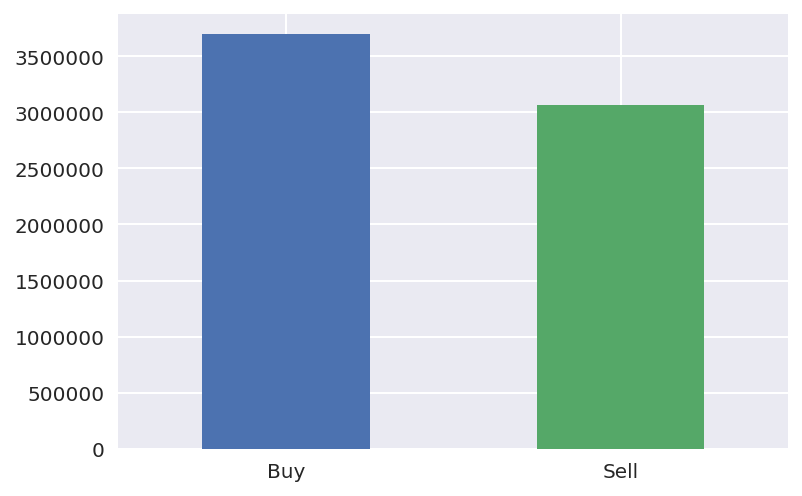

In [18]:
trade.BuySell.value_counts().plot.bar(rot=0)

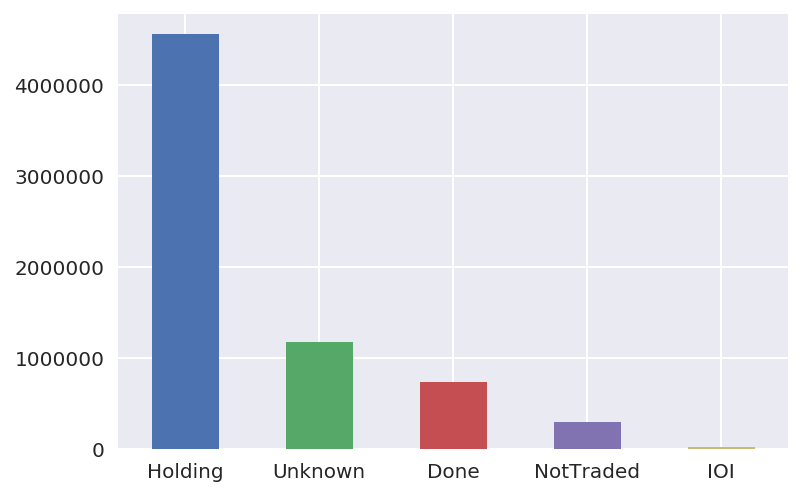

In [19]:
trade.TradeStatus.value_counts().plot.bar(rot=0)

In [27]:
trade.TradeDateKey.nunique()

684

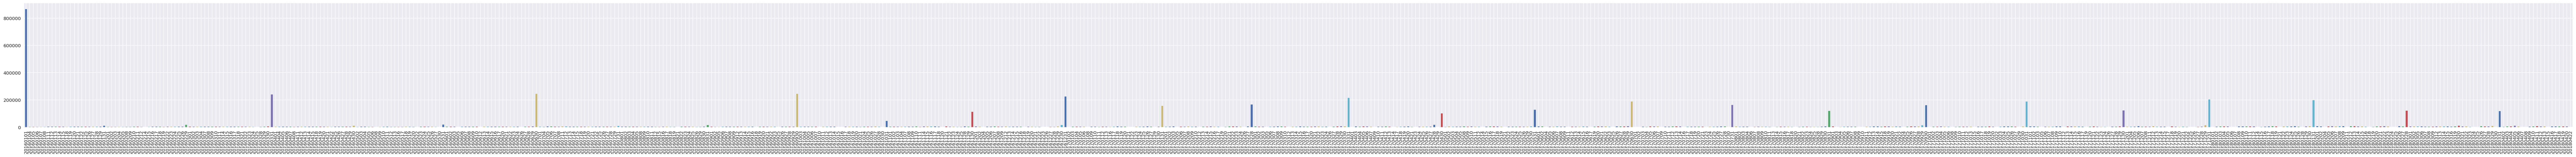

In [28]:
# Activity increases at the end of each month
trade.TradeDateKey.value_counts().sort_index().plot.bar(figsize=(100,5))

In [29]:
# There is historical information for all customers in test
set(challenge.CustomerIdx).difference(trade.CustomerIdx)

set()

In [31]:
# There is historical information for all bonds in test
set(challenge.IsinIdx).difference(trade.IsinIdx)

set()

In [33]:
# There is metadata for all customers in test
set(trade.CustomerIdx).difference(customer.CustomerIdx)

set()

In [34]:
# There is metadata for all bonds in test
set(trade.IsinIdx).difference(isin.IsinIdx)

set()

In [46]:
trade.apply(lambda x: sum(x.isnull()), axis=0)

TradeDateKey              0
CustomerIdx               0
IsinIdx                   0
BuySell                   0
NotionalEUR               0
Price               4617933
TradeStatus               0
CustomerInterest          0
dtype: int64

In [38]:
trade.apply(lambda x: sum(x.isnull())/len(x), axis=0)

TradeDateKey        0.000000
CustomerIdx         0.000000
IsinIdx             0.000000
BuySell             0.000000
NotionalEUR         0.000000
Price               0.682922
TradeStatus         0.000000
CustomerInterest    0.000000
dtype: float64

In [47]:
customer.apply(lambda x: sum(x.isnull()), axis=0)

CustomerIdx      0
Sector           0
Subsector      352
Region           0
Country          0
dtype: int64

In [42]:
customer.apply(lambda x: sum(x.isnull())/len(x), axis=0)

CustomerIdx    0.000000
Sector         0.000000
Subsector      0.101412
Region         0.000000
Country        0.000000
dtype: float64

In [45]:
isin.apply(lambda x: sum(x.isnull()), axis=0)

IsinIdx                   0
TickerIdx                 0
ActualMaturityDateKey     0
IssueDateKey              0
Seniority                 0
Currency                  0
ActivityGroup             0
Region                    0
Activity                  0
RiskCaptain               0
Owner                     0
CompositeRating           0
IndustrySector            5
IndustrySubgroup          5
MarketIssue              17
IssuedAmount              0
CouponType                0
dtype: int64

In [43]:
isin.apply(lambda x: sum(x.isnull())/len(x), axis=0)

IsinIdx                  0.000000
TickerIdx                0.000000
ActualMaturityDateKey    0.000000
IssueDateKey             0.000000
Seniority                0.000000
Currency                 0.000000
ActivityGroup            0.000000
Region                   0.000000
Activity                 0.000000
RiskCaptain              0.000000
Owner                    0.000000
CompositeRating          0.000000
IndustrySector           0.000182
IndustrySubgroup         0.000182
MarketIssue              0.000620
IssuedAmount             0.000000
CouponType               0.000000
dtype: float64

In [50]:
macro_nulls = macro.apply(lambda x: sum(x.isnull()), axis=0)

In [53]:
macro_nulls[macro_nulls>0]

SSE               2
DAX               1
EUROSTOXX         1
VSTOXX            2
FTSE100           1
HSI               1
NIKKEI            2
DOWJONES_INDU     1
SP500             1
Swap_BRL10Y       1
Swap_BRL2Y        1
Swap_BRL5Y        1
Swap_CAD2Y        1
Swap_CHF2Y        2
Swap_CNH30Y      29
Swap_CNO30Y      29
Swap_CNY30Y      29
Swap_EUR2Y        1
Swap_GBP10Y       1
Swap_GBP2Y        1
Swap_GBP30Y       1
Swap_GBP5Y        1
Swap_HKD30Y       1
Swap_JPY2Y        2
Swap_NOK2Y        1
Swap_SGD10Y       1
Swap_SGD2Y        1
Swap_SGD30Y       1
Swap_SGD5Y        1
Swap_USD2Y        1
dtype: int64

In [ ]:
macro['']

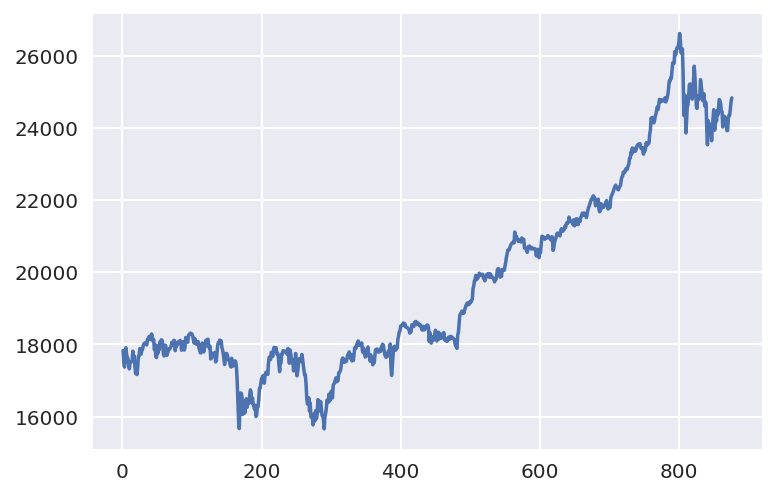

In [56]:
macro['DOWJONES_INDU'].plot()

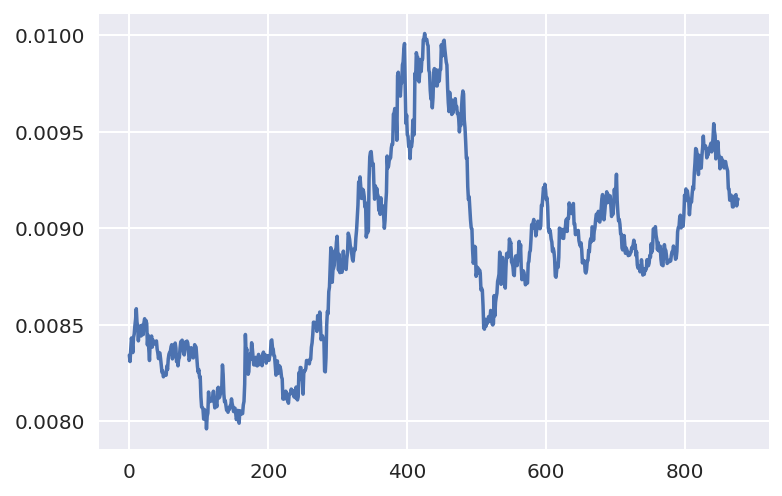

In [57]:
macro['FX_USD.JPY'].plot()

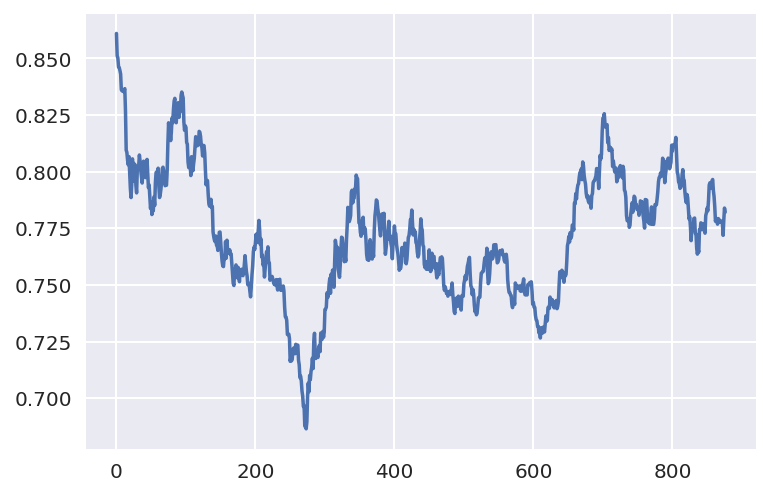

In [58]:
macro['FX_USD.CAD'].plot()

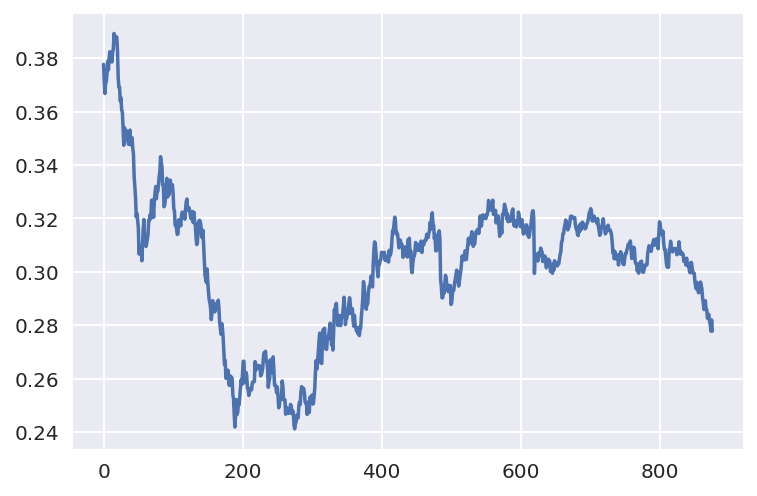

In [59]:
macro['FX_USD.BRL'].plot()

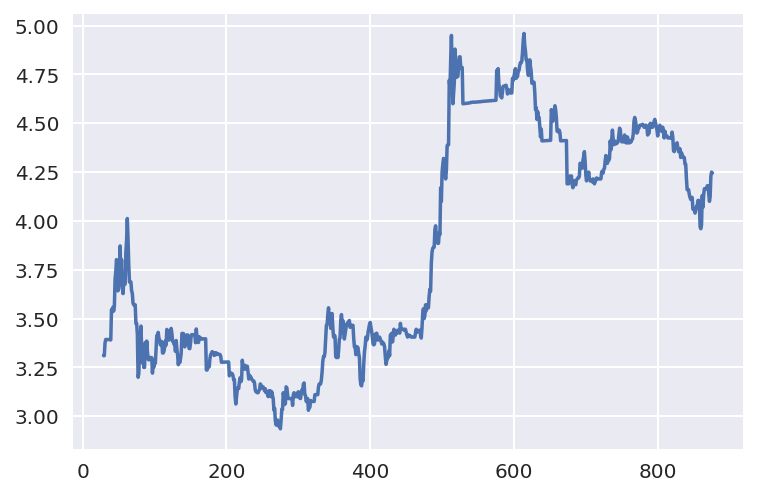

In [60]:
macro['Swap_CNH30Y'].plot()